<a href="https://colab.research.google.com/github/udaybhaskar717/Dphi/blob/main/Predict_Career_Longevity_for_NBA_Rookies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
import warnings
warnings.filterwarnings("ignore")
# Scientific and Data Manipulation Libraries 
import pandas as pd
import numpy as np
import math
import gc
import os
# Data Preprocessing, Machine Learning and Metrics Libraries 
from sklearn.preprocessing            import LabelEncoder, OneHotEncoder 
from sklearn.preprocessing            import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.ensemble                 import VotingClassifier
from sklearn.metrics                  import f1_score
# Boosting Algorithms 
from xgboost                          import XGBClassifier
from catboost                         import CatBoostClassifier
from lightgbm                         import LGBMClassifier
# Data Visualization Libraries 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
data_train =pd.read_csv("/content/Train_data.csv")
data_test =pd.read_csv("/content/Test_data.csv")

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101 entries, 0 to 1100
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GP       1101 non-null   float64
 1   MIN      1101 non-null   float64
 2   FG%      1101 non-null   float64
 3   3P Made  1101 non-null   float64
 4   3P%      1101 non-null   float64
 5   FTA      1101 non-null   float64
 6   FT%      1101 non-null   float64
 7   OREB     1101 non-null   float64
 8   AST      1101 non-null   float64
 9   STL      1101 non-null   float64
 10  BLK      1101 non-null   float64
 11  Target   1101 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 103.3 KB


In [ ]:
data_train["GP"]=data_train["GP"].apply(np.floor)
data_test["GP"]=data_test["GP"].apply(np.floor)

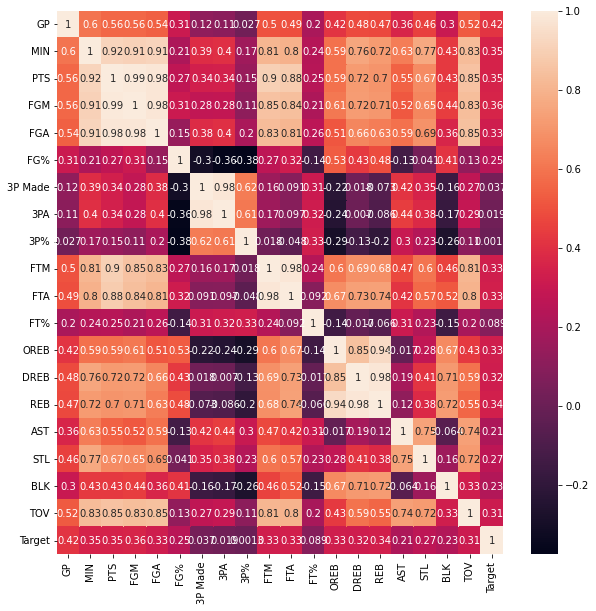

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(data_train.corr(),annot=True)


# Removing correlated data

In [ ]:
def correlation (dataset, threshold):
    col_corr = set()                                     # set of all the names of correlated columns
    corr_mat = dataset.corr()
    for i in range (len(corr_mat.columns)):              #Iterating through the columns of the correlation matrix dataframe
        for j in range (i):
            if abs (corr_mat.iloc[i,j]) > threshold and (corr_mat.columns[j] not in col_corr):    # as perfect negative correlation is also a perfect correlation we are intrested in absolute values
                colname = corr_mat.columns [i]                                  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [ ]:
corr_features = correlation (data_train, 0.8)
len(set(corr_features))

8

In [ ]:
corr_features

{'3PA', 'DREB', 'FGA', 'FGM', 'FTM', 'PTS', 'REB', 'TOV'}

In [ ]:
data_train.drop(corr_features, axis=1 , inplace=True)

In [ ]:
data_test.drop(corr_features, axis=1 , inplace=True)

In [ ]:
data_train

,GP,MIN,FG%,3P Made,3P%,FTA,FT%,OREB,AST,STL,BLK,Target
0,59.0,12.8,51.0,0.2,50.0,0.8,78.0,1.1,0.5,0.3,0.4,1
1,31.0,10.7,35.3,0.5,25.8,0.9,55.2,0.3,0.4,0.3,0.1,0
2,48.0,9.3,49.7,0.0,0.0,1.9,61.5,0.4,0.8,0.5,0.4,0
3,80.0,27.7,37.4,1.3,32.9,3.3,85.0,0.8,3.9,1.3,0.1,1
4,58.0,18.4,36.7,0.0,25.0,3.1,61.7,0.5,1.9,1.1,0.2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1096,49.0,8.3,46.6,0.0,0.0,1.2,70.2,0.6,0.5,0.3,0.3,1
1097,35.0,5.5,36.0,0.4,33.3,0.1,100.0,0.1,0.2,0.1,0.0,1
1098,65.0,13.2,41.3,0.1,35.0,1.0,76.9,0.6,1.1,0.7,0.3,0
1099,55.0,14.9,41.7,0.1,37.5,0.8,76.1,0.5,1.5,0.7,0.2,0


In [ ]:
data_test

,GP,MIN,FG%,3P Made,3P%,FTA,FT%,OREB,AST,STL,BLK
0,44.0,13.0,45.3,0.4,32.7,1.7,65.3,0.8,1.1,0.7,0.2
1,51.0,9.1,39.0,0.1,23.5,0.8,69.8,0.3,0.9,0.6,0.1
2,51.0,15.1,41.2,0.3,32.5,1.6,69.1,0.4,2.1,0.7,0.0
3,15.0,7.9,27.0,0.0,0.0,0.8,66.7,0.5,0.5,0.1,0.1
4,36.0,14.4,43.1,0.0,50.0,1.4,82.0,1.1,0.9,0.3,0.2
...,...,...,...,...,...,...,...,...,...,...,...
550,39.0,22.2,44.6,0.0,0.0,3.1,83.2,1.0,1.3,0.6,0.1
551,62.0,13.0,42.9,0.0,33.3,1.1,70.1,0.3,1.7,0.6,0.1
552,46.0,22.5,58.6,0.0,0.0,3.6,66.5,3.1,0.8,0.7,1.0
553,53.0,6.3,50.0,0.1,33.3,0.4,35.0,0.3,0.2,0.3,0.0


In [ ]:
def data_scaling( scaling_strategy , scaling_data , scaling_columns ):
    
    if    scaling_strategy =="RobustScaler" :
        scaling_data[scaling_columns] = RobustScaler().fit_transform(scaling_data[scaling_columns])
        
    elif  scaling_strategy =="StandardScaler" :
        scaling_data[scaling_columns] = StandardScaler().fit_transform(scaling_data[scaling_columns])
        
    elif  scaling_strategy =="MinMaxScaler" :
        scaling_data[scaling_columns] = MinMaxScaler().fit_transform(scaling_data[scaling_columns])
        
    elif  scaling_strategy =="MaxAbsScaler" :
        scaling_data[scaling_columns] = MaxAbsScaler().fit_transform(scaling_data[scaling_columns])
        
    else :  # If any other scaling send by mistake still perform Robust Scalar
        scaling_data[scaling_columns] = RobustScaler().fit_transform(scaling_data[scaling_columns])
    
    return scaling_data

In [ ]:
scaling_strategy = ["RobustScaler", "StandardScaler","MinMaxScaler","MaxAbsScaler"]
X_train_scale = data_scaling( scaling_strategy[1] , data_train.iloc[:,:-1],data_train.iloc[:,:-1].columns )
X_test_scale  = data_scaling( scaling_strategy [1] , data_test , data_test.columns )

In [ ]:
Classifiers = {'0._XGBoost' : XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5,subsample = 0.70, verbosity = 0,
                                            scale_pos_weight = 2.5,updater ="grow_histmaker",base_score  = 0.2),
               
               '1.CatBoost' : CatBoostClassifier(learning_rate=0.15, n_estimators=1000, subsample=0.085, 
                                                 max_depth=5, scale_pos_weight=2.5),
               
               '2.LightGBM' : LGBMClassifier(subsample_freq = 2, objective ="binary",importance_type = "gain",
                                             verbosity = -1, max_bin = 60,num_leaves = 300,
                                             boosting_type = 'dart',learning_rate=0.15, 
                                             n_estimators=1500, max_depth=5, scale_pos_weight=2.5)
 }

print( list(Classifiers.keys()) )
print( list(Classifiers.values()) )

['0._XGBoost', '1.CatBoost', '2.LightGBM']
[XGBClassifier(base_score=0.2, max_depth=5, n_estimators=1000,
              scale_pos_weight=2.5, subsample=0.7, updater='grow_histmaker',
              verbosity=0), <catboost.core.CatBoostClassifier object at 0x7f7095d79490>, LGBMClassifier(boosting_type='dart', importance_type='gain', learning_rate=0.15,
               max_bin=60, max_depth=5, n_estimators=1500, num_leaves=300,
               objective='binary', scale_pos_weight=2.5, subsample_freq=2,
               verbosity=-1)]


In [ ]:
ensemble_model_2 = VotingClassifier(estimators=[
                                              ('XGBoost_Best', list(Classifiers.values())[0]), 
                                              ('CatBoost_Best', list(Classifiers.values())[1]),
                                              ('LightGBM_Best', list(Classifiers.values())[2]),
                                             ], 
                                              voting='soft',weights=[5,5,5.2])

file_name = "submission"
ensemble_model_2.fit(X_train_scale,data_train.iloc[:,-1]) 

Predicted_predictions_model_2 = ensemble_model_2.predict_proba( X_test_scale )[::,1]

0:	learn: 0.6413265	total: 2.24ms	remaining: 2.24s
1:	learn: 0.5994895	total: 4.27ms	remaining: 2.13s
2:	learn: 0.5730478	total: 6.2ms	remaining: 2.06s
3:	learn: 0.5503275	total: 8.19ms	remaining: 2.04s
4:	learn: 0.5340267	total: 10.3ms	remaining: 2.06s
5:	learn: 0.5197480	total: 12.5ms	remaining: 2.06s
6:	learn: 0.5140955	total: 14.6ms	remaining: 2.08s
7:	learn: 0.5037651	total: 16.8ms	remaining: 2.09s
8:	learn: 0.4969787	total: 19.1ms	remaining: 2.11s
9:	learn: 0.4916255	total: 21.3ms	remaining: 2.11s
10:	learn: 0.4879716	total: 23.5ms	remaining: 2.12s
11:	learn: 0.4832731	total: 25.8ms	remaining: 2.12s
12:	learn: 0.4801383	total: 28.1ms	remaining: 2.13s
13:	learn: 0.4771722	total: 31.7ms	remaining: 2.23s
14:	learn: 0.4735301	total: 34.8ms	remaining: 2.28s
15:	learn: 0.4699481	total: 38.5ms	remaining: 2.37s
16:	learn: 0.4678583	total: 40.8ms	remaining: 2.36s
17:	learn: 0.4659183	total: 43ms	remaining: 2.34s
18:	learn: 0.4637737	total: 45.2ms	remaining: 2.34s
19:	learn: 0.4624254	tota

In [ ]:
# predictions_2 = [1 if value>=0.50009 else 0 for value in Predicted_predictions_model_2 ] # 
predictions_2 = [int(round(value)) for value in Predicted_predictions_model_2]
Result_Promoted = pd.DataFrame({'prediction' : predictions_2})
pd.DataFrame(Result_Promoted).to_csv(file_name+".csv",index=False)